# Testing feature sets on real data with symbolic regression

The directories below should be specified to run this notebook.

In the data directory, each run (species) corresponds to data table named "Rs0i[species]_data.csv" ("species" refers to the HAMBI species identifier).

In the equation directory, each run (species) is represented by an equation table, which is a modified PySR hall of fame file (pre-computed number of constants as another complexity measure has been added as a column). These files are named "Rs0i[species]_[model]_equations.csv", where model is one of {n_C_rho, n_C_U_rho, F_C_rho, F_C_U_rho} representing a feature set (rho denotes the response variable).

In [1]:
# Observed data directory (input to the PySR algorithm).
data_dir = "/scratch/project_2000746/kiciadov/SR_monod/real_data_inference/data/"  

# Results directory; each species has its own hall of fame equation file, 
# and they include pre-computed custom complexity measure (number of constants).
eq_dir = "/scratch/project_2000746/anthosun/2025SRMO/SR_naive_results/"

Some imports and helper functions...

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sympy import *

In [3]:
# A function to round constants within a symbolic expression
def round_constants(eq, precision=2):
    eq2 = parse_expr(eq)
    for a in preorder_traversal(eq2):
        if isinstance(a, Float):
            str_a = str(np.abs(a))
            
            nz = 0
            if "." in str_a and str_a[0] == "0":
                for c in str_a[2:]:
                    if c != "0":
                        break
                    else:
                        nz += 1
            
            if "e-" in str_a:
                nz = int(str_a.split("-")[-1])

            prec = nz + precision
            eq2 = eq2.subs(a, round(a, prec))

    return eq2


# A function to evaluate expression fit on the observed data
def evaluate_results(eqs, data, response="rho", round_constants=True, precision=3, **kwargs):
    r2s = []
    errs = []
    n_conc = len(data["C"].unique())
    max_t = int(len(data)/n_conc)
    obs_y = data[response]
    
    for eq in eqs["Equation"]:
        eq = eq.replace("^", "**")
        if round_constants:
            eq2 = round_constants(eq, precision=precision)
        else:
            eq2 = parse_expr(eq)
        
        for k, v in kwargs.items():
            exec(str(k) + " = " + str(v))
        
        pred_y = eval(eq)

        observed_all = []
        predicted_all = []
        
        for i in range(n_conc):
            x = obs_y[i*max_t:(i+1)*max_t].index.values
            observed = obs_y[i*max_t:(i+1)*max_t]
            if type(pred_y) == float:
                predicted = [pred_y]*len(x)
            else:
                predicted = pred_y[i*max_t:(i+1)*max_t]

            observed_all += list(observed)
            predicted_all += list(predicted)
            
        err = np.sum(np.abs(np.array(predicted_all) - np.array(observed_all)))/len(data)
        errs.append(err)
        u = np.sum((np.array(observed_all) - np.array(predicted_all))**2)
        v = np.sum((np.array(observed_all) - np.mean(np.array(observed_all)))**2)
        r2s.append(1 - u/v)
    return r2s, errs

In [4]:
species_ids = [6, 105, 403, 1287, 1292, 1299, 1842, 1896, 1972, 1977, 2160, 2164, 2443, 2659, 3031, 3237]
variable_sets = [["n", "C"],
                 ["F", "C"],
                 ["n", "C", "U"],
                 ["F", "C", "U"]]

variable_set_complexity_list = []
variable_set_train_err_dict = {"_".join(x): [] for x in variable_sets}
variable_set_test_err_dict = {"_".join(x): [] for x in variable_sets}

set_1_train_err_df = pd.DataFrame(columns=np.array(species_ids).astype(str))
set_1_test_err_df = pd.DataFrame(columns=np.array(species_ids).astype(str))

set_2_train_err_df = pd.DataFrame(columns=np.array(species_ids).astype(str))
set_2_test_err_df = pd.DataFrame(columns=np.array(species_ids).astype(str))

set_3_train_err_df = pd.DataFrame(columns=np.array(species_ids).astype(str))
set_3_test_err_df = pd.DataFrame(columns=np.array(species_ids).astype(str))

set_4_train_err_df = pd.DataFrame(columns=np.array(species_ids).astype(str))
set_4_test_err_df = pd.DataFrame(columns=np.array(species_ids).astype(str))

set_1_train_r2_df = pd.DataFrame(columns=np.array(species_ids).astype(str))
set_1_test_r2_df = pd.DataFrame(columns=np.array(species_ids).astype(str))

set_2_train_r2_df = pd.DataFrame(columns=np.array(species_ids).astype(str))
set_2_test_r2_df = pd.DataFrame(columns=np.array(species_ids).astype(str))

set_3_train_r2_df = pd.DataFrame(columns=np.array(species_ids).astype(str))
set_3_test_r2_df = pd.DataFrame(columns=np.array(species_ids).astype(str))

set_4_train_r2_df = pd.DataFrame(columns=np.array(species_ids).astype(str))
set_4_test_r2_df = pd.DataFrame(columns=np.array(species_ids).astype(str))


for species in species_ids:
    model = "Rs0i" + str(species) + "_n_C_rho"
    
    eqs = pd.read_csv(eq_dir + model + "_equations.csv").iloc[2:]
    data = pd.read_csv(data_dir + "Rs0i" + str(species) + "_data.csv")
    train_data = data[data["C"].isin(data["C"].unique()[::2])]  # Train dataset
    test_data = data[data["C"].isin(data["C"].unique()[1::2])]  # test dataset
    train_r2s, train_errs = evaluate_results(eqs, train_data, round_constants=False, n="train_data['n']", C="train_data['C']")
    test_r2s, test_errs = evaluate_results(eqs, test_data, round_constants=False, n="test_data['n']", C="test_data['C']")

    for i in range(len(eqs["csts"])):
        set_1_train_err_df.loc[list(eqs["csts"])[i], str(species)] = train_errs[i]
        set_1_test_err_df.loc[list(eqs["csts"])[i], str(species)] = test_errs[i]

        set_1_train_r2_df.loc[list(eqs["csts"])[i], str(species)] = train_r2s[i]
        set_1_test_r2_df.loc[list(eqs["csts"])[i], str(species)] = test_r2s[i]


for species in species_ids:
    model = "Rs0i" + str(species) + "_F_C_rho"

    eqs = pd.read_csv(eq_dir + model + "_equations.csv").iloc[2:]
    data = pd.read_csv(data_dir + "Rs0i" + str(species) + "_data.csv")
    train_data = data[data["C"].isin(data["C"].unique()[::2])]  # Train dataset
    test_data = data[data["C"].isin(data["C"].unique()[1::2])]  # test dataset
    train_r2s, train_errs = evaluate_results(eqs, train_data, round_constants=False, F="train_data['F']", C="train_data['C']")
    test_r2s, test_errs = evaluate_results(eqs, test_data, round_constants=False, F="test_data['F']", C="test_data['C']")

    for i in range(len(eqs["csts"])):
        set_2_train_err_df.loc[list(eqs["csts"])[i], str(species)] = train_errs[i]
        set_2_test_err_df.loc[list(eqs["csts"])[i], str(species)] = test_errs[i]

        set_2_train_r2_df.loc[list(eqs["csts"])[i], str(species)] = train_r2s[i]
        set_2_test_r2_df.loc[list(eqs["csts"])[i], str(species)] = test_r2s[i]


for species in species_ids:
    model = "Rs0i" + str(species) + "_n_C_U_rho"

    eqs = pd.read_csv(eq_dir + model + "_equations.csv").iloc[2:]
    data = pd.read_csv(data_dir + "Rs0i" + str(species) + "_data.csv")
    train_data = data[data["C"].isin(data["C"].unique()[::2])]  # Train dataset
    test_data = data[data["C"].isin(data["C"].unique()[1::2])]  # test dataset
    train_r2s, train_errs = evaluate_results(eqs, train_data, round_constants=False, n="train_data['n']", C="train_data['C']", U="train_data['U']")
    test_r2s, test_errs = evaluate_results(eqs, test_data, round_constants=False, n="test_data['n']", C="test_data['C']", U="test_data['U']")

    for i in range(len(eqs["csts"])):
        set_3_train_err_df.loc[list(eqs["csts"])[i], str(species)] = train_errs[i]
        set_3_test_err_df.loc[list(eqs["csts"])[i], str(species)] = test_errs[i]

        set_3_train_r2_df.loc[list(eqs["csts"])[i], str(species)] = train_r2s[i]
        set_3_test_r2_df.loc[list(eqs["csts"])[i], str(species)] = test_r2s[i]


for species in species_ids:
    model = "Rs0i" + str(species) + "_F_C_U_rho"

    eqs = pd.read_csv(eq_dir + model + "_equations.csv").iloc[2:]
    data = pd.read_csv(data_dir + "Rs0i" + str(species) + "_data.csv")
    train_data = data[data["C"].isin(data["C"].unique()[::2])]  # Train dataset
    test_data = data[data["C"].isin(data["C"].unique()[1::2])]  # test dataset
    train_r2s, train_errs = evaluate_results(eqs, train_data, round_constants=False, F="train_data['F']", C="train_data['C']", U="train_data['U']")
    test_r2s, test_errs = evaluate_results(eqs, test_data, round_constants=False, F="test_data['F']", C="test_data['C']", U="test_data['U']")

    for i in range(len(eqs["csts"])):
        set_4_train_err_df.loc[list(eqs["csts"])[i], str(species)] = train_errs[i]
        set_4_test_err_df.loc[list(eqs["csts"])[i], str(species)] = test_errs[i]

        set_4_train_r2_df.loc[list(eqs["csts"])[i], str(species)] = train_r2s[i]
        set_4_test_r2_df.loc[list(eqs["csts"])[i], str(species)] = test_r2s[i]


In [5]:
err_dfs = [set_1_test_r2_df, set_3_test_r2_df, set_2_test_r2_df, set_4_test_r2_df]
train_err_dfs = [set_1_train_r2_df, set_3_train_r2_df, set_2_train_r2_df, set_4_train_r2_df]
feature_set_names = ["{C, N}", "{C, N, t}", "{C, Nc}", "{C, Nc, t}"]
r2_window_df = pd.DataFrame(columns=["Performance", "Window", "Complexity", "Feature set"])
r2_window_train_df = pd.DataFrame(columns=["Median", "Window", "Complexity", "Feature set"])
for ei in range(len(err_dfs)):
    temp_df = err_dfs[ei].sort_index()
    train_temp_df = train_err_dfs[ei].sort_index()
    wi = 0
    for i in temp_df.index:
        y = np.array(temp_df.loc[i]).reshape(-1)
        y = y[~np.isnan(y.astype(float))]

        r2_window_df = pd.concat([r2_window_df, pd.DataFrame({"Performance": y, "Window": [wi]*len(y), "Complexity": i, "Feature set": [feature_set_names[ei]]*len(y)})])

        train_y = np.array(train_temp_df.loc[i]).reshape(-1)
        train_y = train_y[~np.isnan(train_y.astype(float))]
        
        r2_window_train_df = pd.concat([r2_window_train_df, pd.DataFrame({"Median": np.median(train_y), "Window": [wi], "Complexity": i, "Feature set": [feature_set_names[ei]]})])
        wi += 1


r2_window_train_df = r2_window_train_df.sort_values("Window")
r2_window_train_df['Feature set'] = pd.Categorical(r2_window_train_df['Feature set'], categories=feature_set_names, ordered=True)
r2_window_train_df = r2_window_train_df.assign(n=r2_window_train_df.groupby('Feature set', observed=True).cumcount()).sort_values(by=['Window', 'Feature set'])

/run/nvme/job_27666069/tmp/ipykernel_3588733/26602672.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  r2_window_train_df = pd.concat([r2_window_train_df, pd.DataFrame({"Median": np.median(train_y), "Window": [wi], "Complexity": i, "Feature set": [feature_set_names[ei]]})])


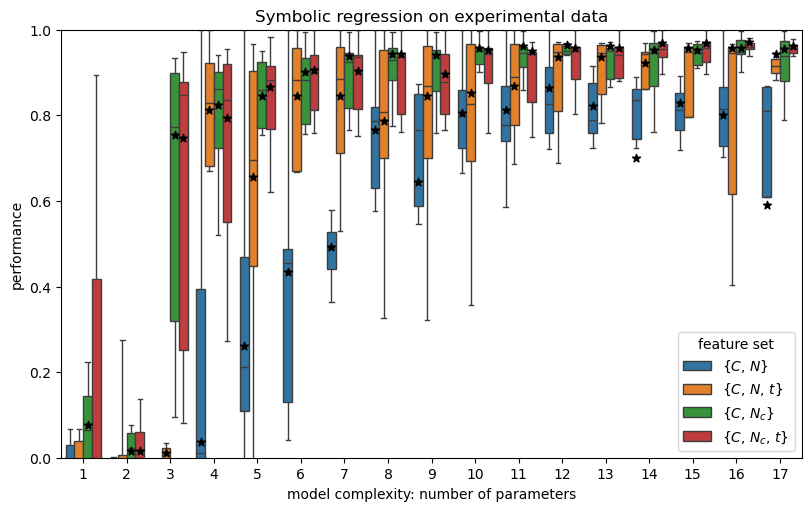

In [6]:
r2_window_df = r2_window_df.replace({"Feature set": {"{C, N}": r"{$C$, $N$}", "{C, N, t}": r"{$C$, $N$, $t$}", "{C, Nc}": r"{$C$, $N_c$}", "{C, Nc, t}": r"{$C$, $N_c$, $t$}"}})

plt.figure(figsize=(8, 5), constrained_layout=True)
sns.boxplot(data=r2_window_df, y="Performance", x="Window", hue="Feature set", showfliers=False, zorder=0)

x = np.arange(-0.5, 22, 0.2)
x = [x[i] for i in range(len(x)) if i%5 != 0]

for i in range(len(x)):
    plt.scatter(x[i], r2_window_train_df.iloc[i, 0], color="k", marker="*", zorder=1)

upper_window_complexity = [r2_window_df[r2_window_df["Window"] == window]["Complexity"].max() for window in sorted(r2_window_df["Window"].unique())]

plt.xticks(range(len(r2_window_df["Window"].unique())), upper_window_complexity)
plt.ylabel("performance")
plt.xlabel("model complexity: number of parameters")
plt.legend(loc="lower right", title="feature set")
plt.ylim(0, 1)
plt.xlim(-0.5, 16.5)
plt.title("Symbolic regression on experimental data")
# plt.savefig("SR_complexities_R.png")
plt.show()